In [31]:
# %load "E:\_Python\raindrop_simulation\raindrop_simulation.py"
import tensorflow as tf
import numpy as np

import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


def DisplayArray(a, fmt='jpeg', rng=[0, 1]):
    """Display an array as a picture."""
    a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    img = Image(data=f.getvalue())
    display(img)


def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)


def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]


def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                             [1.0, -6., 1.0],
                             [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

def rain_droping(u):
    u_=u.eval()
    for n in range(10): 
        a, b = np.random.randint(0, N, 2)
        u_[a, b] = np.random.uniform()
    u.assign(u_)
    
    
def tensor_expand(tensor_Input,Num):
    '''
    张量自我复制扩展，将Num个tensor_Input串联起来，生成新的张量，
    新的张量的shape=[tensor_Input.shape,Num]
    :param tensor_Input:
    :param Num:
    :return:
    '''
    tensor_Input = tf.expand_dims(tensor_Input,axis=0)
    tensor_Output = tensor_Input
    for i in range(Num-1):
        tensor_Output= tf.concat([tensor_Output,tensor_Input],axis=0)
    return tensor_Output

    
def get_one_hot_matrix(height,width,position):
    '''
    生成一个 one_hot矩阵，shape=【height*width】，在position处的元素为1，其余元素为0
    :param height:
    :param width:
    :param position: 格式为【h_Index,w_Index】,h_Index,w_Index为int格式
    :return:
    '''
    col_length = height
    row_length = width
    col_one_position = position[0]
    row_one_position = position[1]
    rows_num = height
    cols_num = width
 
    single_row_one_hot = tf.one_hot(row_one_position, row_length, dtype=tf.float32)
    single_col_one_hot = tf.one_hot(col_one_position, col_length, dtype=tf.float32)
 
    one_hot_rows = tensor_expand(single_row_one_hot, rows_num)
    one_hot_cols = tensor_expand(single_col_one_hot, cols_num)
    one_hot_cols = tf.transpose(one_hot_cols)
 
    one_hot_matrx = one_hot_rows * one_hot_cols
    return one_hot_matrx


def update_mi(height,width,c):
    for n in range(c): 
        x, y = np.random.randint(0, N, 2)
        mi[x,y]=1


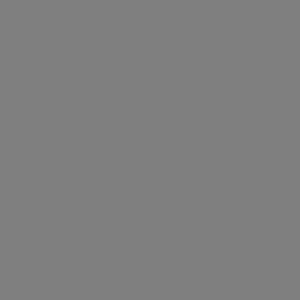

In [32]:
N = 300

# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype="float32")
ut_init = np.zeros([N, N], dtype="float32")

# Some rain drops hit a pond at random points

mi=np.zeros([N,N], dtype="float32")
matrix =tf.Variable(mi)

DisplayArray(u_init, rng=[-0.1, 0.1])

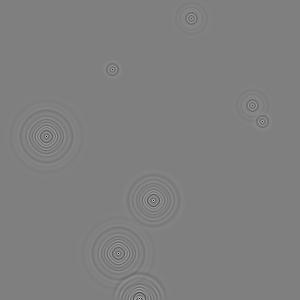

In [33]:
sess = tf.InteractiveSession()

# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(U.assign(U_), Ut.assign(Ut_))

# Initialize state to initial conditions
tf.initialize_all_variables().run()

# Run 1000 steps of PDE
for i in range(1000):
    if i%250==0:
        # add 10 raindrops per range
        update_mi(N, N,2)
        
        new_raindrops= tf.group(matrix.assign(mi) ,U.assign(U - U*matrix +matrix*np.random.uniform()))
        new_raindrops.run()
            
    # Step simulation
    step.run({eps: 0.03, damping: 0.04})
    
    # Visualize every 50 steps
    if i % 50 == 0:
        clear_output()
        DisplayArray(U.eval(), rng=[-0.1, 0.1])
